In [73]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import cv2
import seaborn as sns
import glob
import xml.etree.ElementTree as ET
from PIL import Image
import os
import shutil
import json
from pathlib import Path

In [74]:
base_dir = "/Users/tim/Downloads/CV_dataset"  # For MAC
print(f"Dataset Folder found: {os.path.exists(base_dir)}")

ann_dir = os.path.join(base_dir, "ann")
img_dir = os.path.join(base_dir, "img")


ann_count = len(glob.glob(os.path.join(ann_dir, "*.txt")))
img_count = len(glob.glob(os.path.join(img_dir, "*.png")) +
             glob.glob(os.path.join(img_dir, "*.jpg")) +
             glob.glob(os.path.join(img_dir, "*.jpeg")))

print(f"Images found: {img_count}")
print(f"Annotations found: {ann_count}")

Dataset Folder found: True
Images found: 5711
Annotations found: 5711


In [83]:
def visualize_yolo_masks(num_samples=4):
    """Visualize images with YOLO segmentation masks, skipping empty annotations"""

    # Get ALL image files (PNG, JPG, JPEG)
    image_files = (glob.glob(os.path.join(img_dir, "*.png")) +
                   glob.glob(os.path.join(img_dir, "*.jpg")) +
                   glob.glob(os.path.join(img_dir, "*.jpeg")))

    if not image_files:
        print(f"❌ No image files found in {img_dir}")
        return

    print(f"Found {len(image_files)} images")

    # Filter out images with empty annotations
    valid_image_files = []

    for image_file in image_files:
        # FIX: Keep the image extension in the annotation filename
        image_filename = os.path.basename(image_file)
        label_file = os.path.join(ann_dir, image_filename + ".txt")

        # Check if annotation file exists and is not empty
        if os.path.exists(label_file):
            with open(label_file, 'r') as f:
                content = f.read().strip()

            # Skip if file is empty or has no valid annotations
            if len(content) == 0:
                continue

            # Check if there are any valid person annotations
            lines = content.split('\n')
            has_person = False
            for line in lines:
                parts = line.strip().split()
                if len(parts) >= 6:  # Valid YOLO segmentation line
                    class_id = int(parts[0])
                    if class_id == 0:  # Person class
                        has_person = True
                        break

            if has_person:
                valid_image_files.append(image_file)

    print(f"Found {len(valid_image_files)} images with valid person annotations")
    print(f"Skipping {len(image_files) - len(valid_image_files)} images with empty/no-person annotations\n")

    if not valid_image_files:
        print("No valid images with person annotations found!")
        return

    # Show first few samples from valid images
    samples_shown = 0
    for i, image_file in enumerate(valid_image_files):
        if samples_shown >= num_samples:
            break

        # Load image
        image = cv2.imread(image_file)
        if image is None:
            print(f"Could not load image: {image_file}")
            continue

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        height, width = image.shape[:2]

        # Get annotation file
        image_filename = os.path.basename(image_file)
        label_file = os.path.join(ann_dir, image_filename + ".txt")

        print(f"Sample {samples_shown+1}: {os.path.basename(image_file)}")

        # Create a copy for drawing
        image_with_mask = image.copy()

        # Read YOLO segmentation annotations
        with open(label_file, 'r') as f:
            lines = f.readlines()

        person_count = 0
        for line in lines:
            parts = line.strip().split()
            if len(parts) < 6:
                continue

            # Parse YOLO segmentation format
            class_id = int(parts[0])
            polygon_points = []

            # Parse polygon points (skip first 5 bbox values)
            for j in range(5, len(parts), 2):
                if j + 1 < len(parts):
                    x = float(parts[j]) * width
                    y = float(parts[j + 1]) * height
                    polygon_points.append([x, y])

            # Draw polygon mask
            if len(polygon_points) > 2:
                pts = np.array(polygon_points, np.int32)

                # Create filled mask
                mask = np.zeros((height, width), dtype=np.uint8)
                cv2.fillPoly(mask, [pts], 255)

                # Create colored overlay
                overlay = image_with_mask.copy()
                cv2.fillPoly(overlay, [pts], (255, 0, 0))  # Blue fill

                # Blend overlay with original image
                alpha = 0.3  # Transparency
                image_with_mask = cv2.addWeighted(overlay, alpha, image_with_mask, 1 - alpha, 0)

                # Draw polygon outline
                cv2.polylines(image_with_mask, [pts], True, (0, 255, 0), 2)  # Green outline

                # Draw bounding box
                bbox_x = float(parts[1]) * width
                bbox_y = float(parts[2]) * height
                bbox_w = float(parts[3]) * width
                bbox_h = float(parts[4]) * height

                x1 = int(bbox_x - bbox_w / 2)
                y1 = int(bbox_y - bbox_h / 2)
                x2 = int(bbox_x + bbox_w / 2)
                y2 = int(bbox_y + bbox_h / 2)

                cv2.rectangle(image_with_mask, (x1, y1), (x2, y2), (255, 255, 0), 2)  # Cyan bbox

                # Add label
                cv2.putText(image_with_mask, f'Person {class_id}', (x1, y1 - 10),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)

                person_count += 1

        # Display
        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.title(f"Original: {os.path.basename(image_file)}")
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(image_with_mask)
        plt.title(f"With Masks: {person_count} person(s)")
        plt.axis('off')

        plt.tight_layout()
        plt.show()

        samples_shown += 1

#visualize_yolo_masks(num_samples=4)

Found 5711 images
Found 4474 images with valid person annotations
Skipping 1237 images with empty/no-person annotations

Sample 1: softball-player-female-glove-163330.png


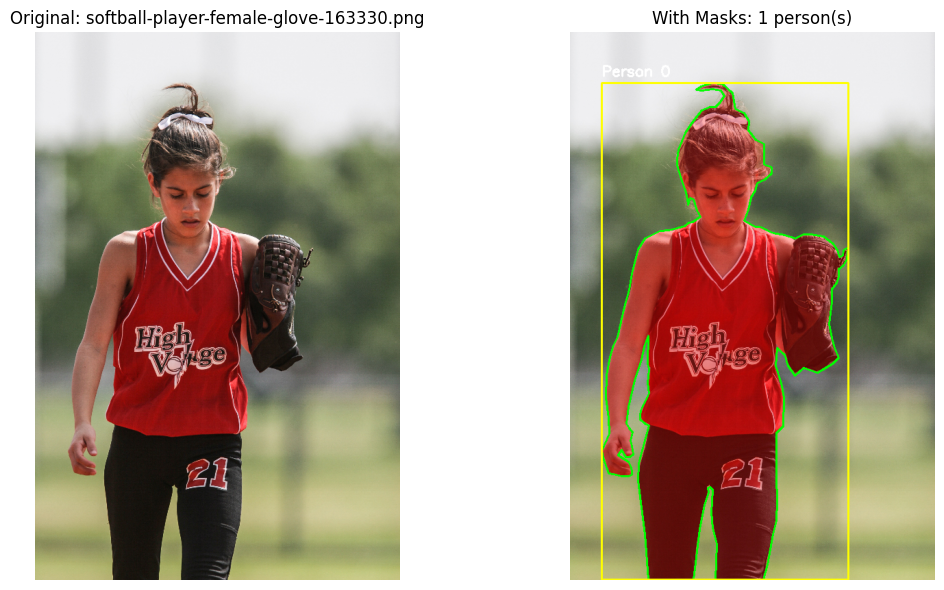

Sample 2: pexels-photo-300968.png


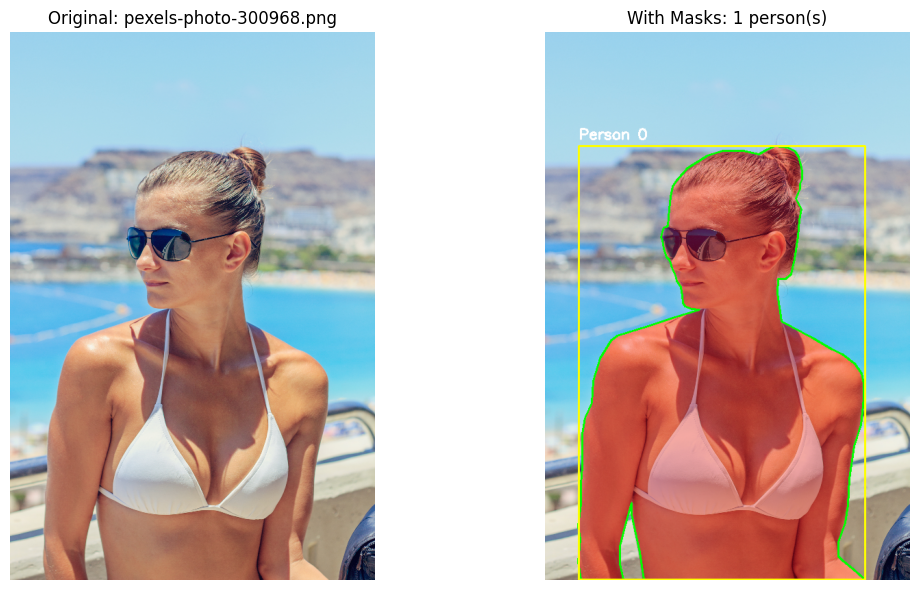

Sample 3: pexels-photo-219593.png


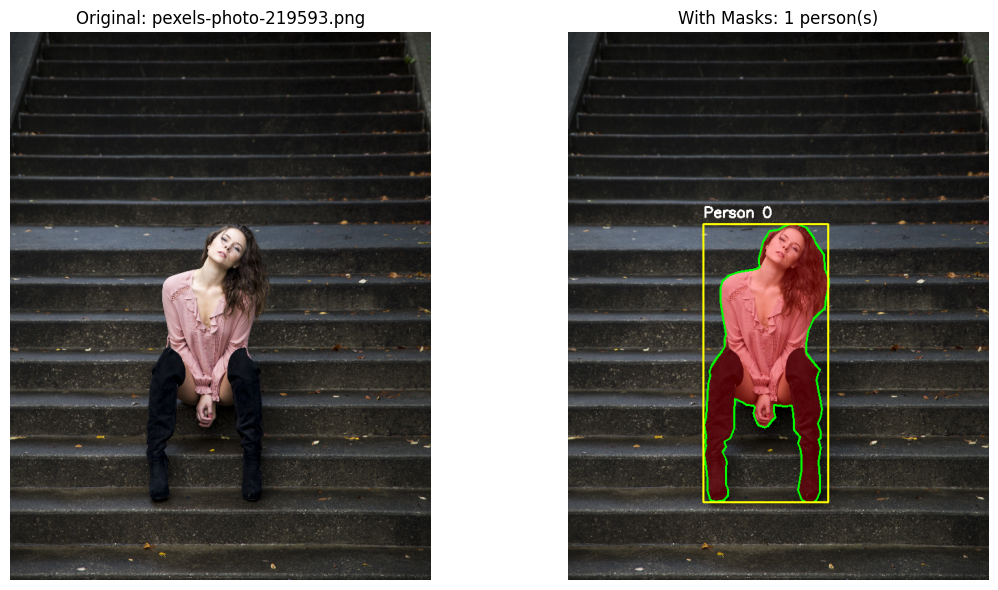

Sample 4: pexels-photo-246097.png


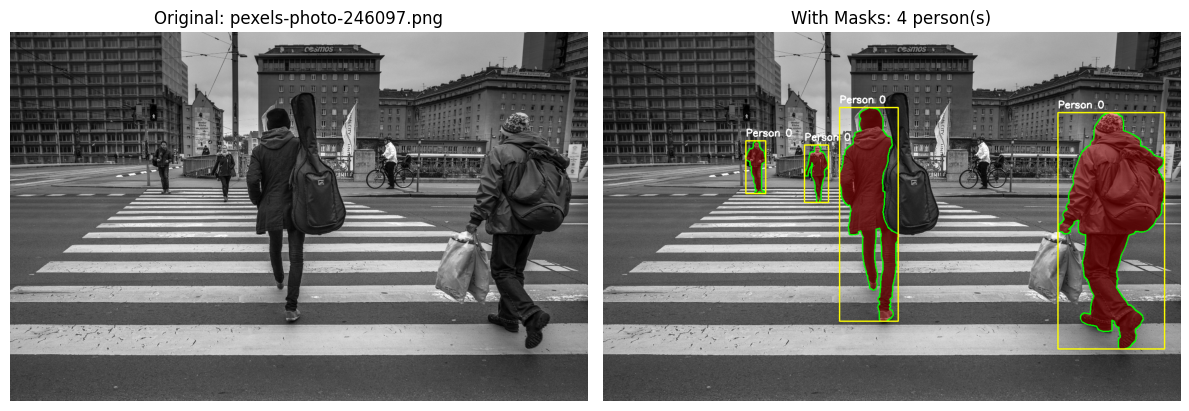

Sample 5: fashion-hat-attractive-elegant-157971.png


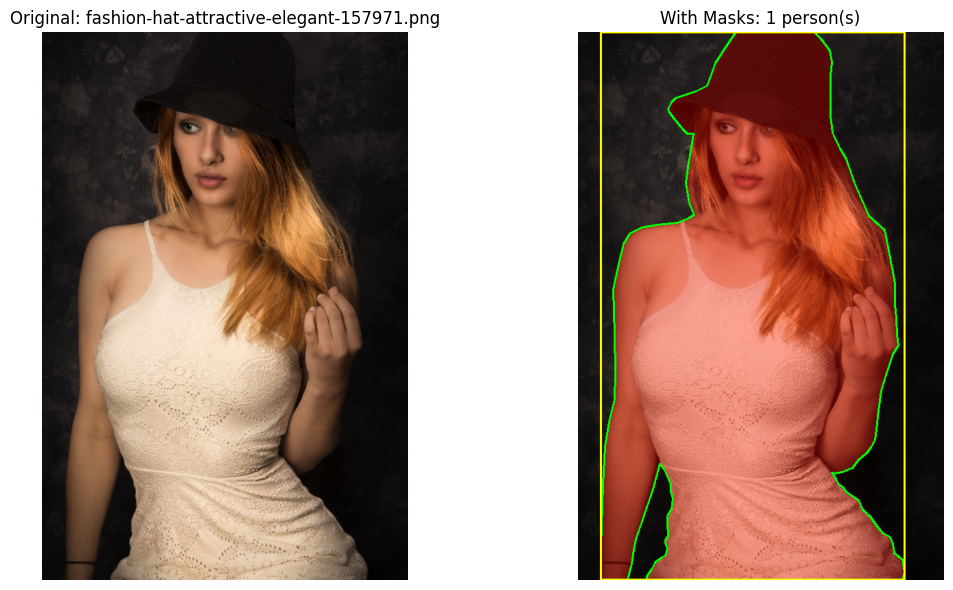

In [85]:
visualize_yolo_masks(5)

In [88]:
# Create dataset.yaml
yaml_content = f"""
path: {base_dir}
train: images/train
val: images/val

# Number of classes
nc: 1

# Class names
names: ['person']

# For segmentation
task: segment
"""

yaml_path = os.path.join(base_dir, "dataset.yaml")
with open(yaml_path, 'w') as f:
    f.write(yaml_content)

print(f"YAML created in {yaml_path}")

YAML created in /Users/tim/Downloads/CV_dataset/dataset.yaml


In [90]:
# Split data
def split_train_val():
    # Get all valid image files (with annotations)
    image_files = (glob.glob(os.path.join(img_dir, "*.png")) +
                   glob.glob(os.path.join(img_dir, "*.jpg")) +
                   glob.glob(os.path.join(img_dir, "*.jpeg")))

    # Filter to only include images with valid annotations
    valid_images = []
    for img_file in image_files:
        img_filename = os.path.basename(img_file)
        ann_file = os.path.join(ann_dir, img_filename + ".txt")
        if os.path.exists(ann_file):
            with open(ann_file, 'r') as f:
                if f.read().strip():  # Not empty
                    valid_images.append(img_file)

    # Split 80/20 like fruit example
    np.random.seed(42)
    np.random.shuffle(valid_images)
    split_idx = int(0.8 * len(valid_images))
    train_files = valid_images[:split_idx]
    val_files = valid_images[split_idx:]

    print(f"Training: {len(train_files)}, Validation: {len(val_files)}")
    return train_files, val_files

train_files, val_files = split_train_val()

Training: 3579, Validation: 895


In [92]:
# Create final directory structure
final_data_dir = os.path.join(base_dir, "Final_data")
os.makedirs(os.path.join(final_data_dir, "images", "train"), exist_ok=True)
os.makedirs(os.path.join(final_data_dir, "images", "val"), exist_ok=True)
os.makedirs(os.path.join(final_data_dir, "labels", "train"), exist_ok=True)
os.makedirs(os.path.join(final_data_dir, "labels", "val"), exist_ok=True)

# Copy files to train/val folders (like fruit example)
def organize_final_data(train_files, val_files):
    for img_file in train_files:
        # Copy image
        img_filename = os.path.basename(img_file)
        shutil.copy(img_file, os.path.join(final_data_dir, "images", "train", img_filename))

        # Copy annotation
        ann_file = os.path.join(ann_dir, img_filename + ".txt")
        shutil.copy(ann_file, os.path.join(final_data_dir, "labels", "train", img_filename + ".txt"))

    for img_file in val_files:
        # Copy image
        img_filename = os.path.basename(img_file)
        shutil.copy(img_file, os.path.join(final_data_dir, "images", "val", img_filename))

        # Copy annotation
        ann_file = os.path.join(ann_dir, img_filename + ".txt")
        shutil.copy(ann_file, os.path.join(final_data_dir, "labels", "val", img_filename + ".txt"))

    print("Data organized into train/val folders")

organize_final_data(train_files, val_files)

Data organized into train/val folders


In [93]:
# Update YAML to point to final data
yaml_content = f"""
path: {final_data_dir}
train: images/train
val: images/val

nc: 1
names: ['person']

task: segment
"""

with open(yaml_path, 'w') as f:
    f.write(yaml_content)

In [ ]:
# Install ultralytics if not already installed
# !pip install ultralytics

from ultralytics import YOLO

# Load a pre-trained YOLO segmentation model
model = YOLO('yolov8n-seg.pt')  # Segmentation model

# Train the model (like fruit example)
def train_model():
    results = model.train(
        data=yaml_path,
        epochs=10,
        patience=10,
        batch=8,
        lr0=0.0005,
        imgsz=640,
        name='person_segmentation'
    )
    return results

train_model()

Ultralytics 8.3.218 🚀 Python-3.13.7 torch-2.9.0 CPU (Apple M3)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/Users/tim/Downloads/CV_dataset/dataset.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0005, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n-seg.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=person_segmentation2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=10, perspective=0.0, plot